# Magics

In [26]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Module Imports

In [27]:
import os
import glob
import pickle
import string
from tqdm.notebook import tqdm

import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable, Size, Divider
import matplotlib.colors as mcolors

from Preprocessing_Methods import *
from bl_plots_new import *


# Import Data

In [28]:
file_names = glob.glob('/mnt/c/Users/conor/OneDrive/Desktop/temp_extraction_new/*')

annotations = dict()

for file_name in tqdm(file_names):
    for i in [1,2]:
        try:
            annotations[f"{file_name.split('/')[-1][:-4]}"] = matplotlib.image.imread(f"/mnt/c/Users/conor/Google Drive/PHD/Project with Janet/Label_Images/TMA_{i}/{file_name.split('/')[-1][:-4]}.png")  
            continue

        except FileNotFoundError as e:

            pass
            #print(f'{file_name} not found')

In [29]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, FunctionTransformer, normalize

In [30]:
master = pd.read_excel('/mnt/c/Users/conor/OneDrive/Desktop/master_xl_1507.xlsx')
gb = list(master.groupby('REF'))

In [31]:
gb[0][1]

,Unnamed: 0,HE,REF,TMA,ANN,FTIR
0,0,/mnt/c/Users/conor/Google Drive/PhD/H&E_Cores/...,TMA_1_A10,TMA_1,/mnt/c/Users/conor/Google Drive/PHD/Project wi...,/mnt/c/Users/conor/OneDrive/Desktop/temp_extra...
1,1,/mnt/c/Users/conor/Google Drive/PhD/H&E_Cores/...,TMA_1_A10,TMA_1,/mnt/c/Users/conor/Google Drive/PHD/Project wi...,/mnt/c/Users/conor/OneDrive/Desktop/temp_extra...


In [51]:
total = pd.read_pickle('./Original_Data.pickle')
total['1yeardeath'] = (total.reset_index()['survival (months)']<12).values & (total.reset_index('DiedvsAlive')['DiedvsAlive']=='Died').values
total = total.set_index('1yeardeath', append=True)
total = truncate(total, start=1000, end=1800)

In [54]:
total.reset_index('2year')['2year'].value_counts()

True     151408
False    150695
Name: 2year, dtype: int64

In [55]:
patients = total.reset_index().groupby('Patient_Number').sample(1).iloc[:,:43]

In [57]:
patients['2year'].value_counts()

False    19
True     15
Name: 2year, dtype: int64

In [34]:
# Truncate and eliminate paraffin contribution

total_p = pd.DataFrame(FunctionTransformer(normalize, kw_args = {"axis": 1}).fit_transform(total), index=total.index, columns=total.columns)
total_p = total_p.sample(frac=1)

# Demographics Table

In [35]:
def range_(array):

    return f'{array.min()} - {array.max()}'


In [36]:
tables = dict()

for marg, pred_name in zip([True, True], ['1yeardeath', '2year']):

    age = patients.pivot_table('age @ diag', pred_name, aggfunc=[np.mean, range_, np.median]).T
    gen = pd.crosstab(patients['gender'], patients[pred_name], margins=marg)
    T = pd.crosstab(patients['T stage'], patients[pred_name], margins=marg)
    N = pd.crosstab(patients['N stage'], patients[pred_name], margins=marg)
    Site = pd.crosstab(patients['site'], patients[pred_name], margins=marg)

    pd.concat([age, gen, T, N, Site]).to_latex(f'./Prognosis_Paper_Plots/Tables/{pred_name}_table.txt')

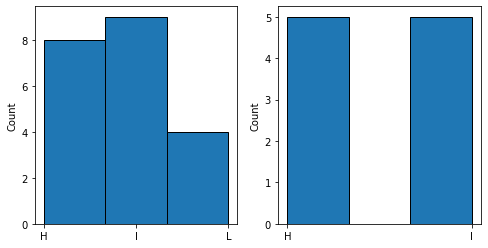

In [37]:
fig, axes = plt.subplots(ncols=2, figsize=(8,4))

for ax, (name, df) in zip(axes, patients.groupby('1yeardeath')):

    df.sort_values(by='ASMA')['ASMA'].hist(ax=ax, bins=3, edgecolor='black', grid=False, histtype='barstacked', rwidth=1.0)
    ax.set_ylabel('Count')

In [38]:
pd.crosstab(index=[patients['2year'], patients['ASMA']], columns='Patient_Number', aggfunc=len, values=patients['1yeardeath'], margins=True).iloc[:-1,:]

col_0       Patient_Number  All
2year ASMA                     
False H                  5    5
      I                  8    8
      L                  3    3
True  H                  8    8
      I                  6    6
      L                  1    1

# Annotation Plots

TMA_1_D5


<ipython-input-39-0f3d525eaa47>:14: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(wspace=0)


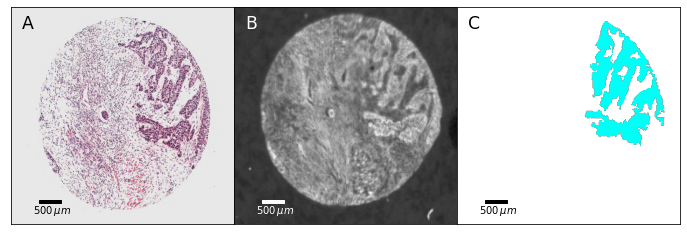

In [39]:
row = gb[29]

name = row[0]
print(name)

df1 = row[1].iloc[0,:]

ftir = pd.read_hdf(df1['FTIR'], key='Data')
ann = matplotlib.image.imread(df1['ANN'])
he1 = matplotlib.image.imread(df1['HE'])


fig, axes = plt.subplots(ncols=3, figsize=(12,4), constrained_layout = True)
fig.subplots_adjust(wspace=0)
[(ax.set_xticks([]), ax.set_yticks([])) for ax in axes];


sbx, sby = 0.1, 0.05
sb = 500

axes[0].imshow(he1,aspect='auto')
axes[0].text(0.05, 0.9, 'A', size='xx-large', transform=axes[0].transAxes)
axes[0].add_patch(Rectangle((sbx+0.025, 0.1), 0.1, 0.01, color='black', transform=axes[0].transAxes))
axes[0].text(sbx, sby, f'${sb}\/\mu m$', size='medium', transform=axes[0].transAxes)


axes[1].imshow(ftir.values.reshape(256,256,-1)[10:-15,:,195],aspect='auto', cmap='gray')
axes[1].text(0.05, 0.9, 'B', size='xx-large', color='w', transform=axes[1].transAxes)
axes[1].add_patch(Rectangle((sbx+0.025, 0.1), 0.1, 0.01, color='w', transform=axes[1].transAxes))
axes[1].text(sbx, sby, f'${sb}\/\mu m$', size='medium', color='w', transform=axes[1].transAxes)


axes[2].imshow(ann[10:-15,:,:],aspect='auto')
axes[2].text(0.05, 0.9, 'C', size='xx-large', transform=axes[2].transAxes)
axes[2].add_patch(Rectangle((sbx+0.025, 0.1), 0.1, 0.01, color='black', transform=axes[2].transAxes))
axes[2].text(sbx, sby, f'${sb}\/\mu m$', size='medium', transform=axes[2].transAxes)


fig.savefig('./Prognosis_Paper_Plots/Annotation.pdf', bbox_inches='tight')

# ROC Curves

In [40]:
names = ['1yd_ASMA', '1yd_no_ASMA','2yd_ASMA', '2yd_no_ASMA']

filt_dicts = dict()
unfilt_dicts = dict()

for filt_type, result_dict in zip(['Filtered', 'Unfiltered'], [filt_dicts, unfilt_dicts]):

    folder = f'/mnt/c/Users/conor/Git_Projects/PHD/Prognosis_Results/bare_results/{filt_type}/*.pickle'

    file_names = glob.glob(folder)

    for name, fn in zip(names, file_names):

        with open(fn, 'rb') as file:

            result_dict[name] = pickle.load(file)


joined_sets = pd.concat({k: pd.DataFrame(v['Normal LR']['Stats']) for k, v in unfilt_dicts.items()})#.groupby(level=0).hist()
joined_sets.index.set_names(['Set', 'Sample'], [0,1], inplace=True)

<ipython-input-41-444831642ff5>:2: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(wspace=0)


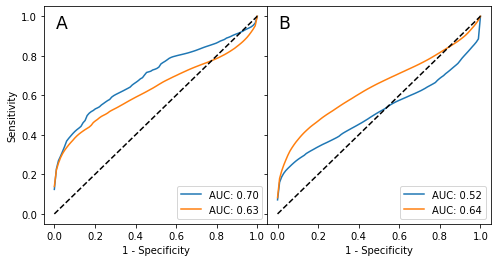

In [41]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4), sharey=True, constrained_layout = True)
fig.subplots_adjust(wspace=0)

x = np.linspace(0,1,100)

auc1 = np.mean(unfilt_dicts['1yd_ASMA']['Normal LR']['Stats']['AUC'])
ax1.plot(x, unfilt_dicts['1yd_ASMA']['Normal LR']['ROC Curves'].mean(axis=0), label=f'AUC: {auc1:0.2f}')

auc2 = np.mean(unfilt_dicts['1yd_no_ASMA']['Normal LR']['Stats']['AUC'])
ax1.plot(x, unfilt_dicts['1yd_no_ASMA']['Normal LR']['ROC Curves'].mean(axis=0), label=f'AUC: {auc2:0.2f}')

ax1.plot([0,1],[0,1], ls='--', c='black')
ax1.set_xlabel('1 - Specificity')
ax1.set_ylabel('Sensitivity')
ax1.text(0.05, 0.9, 'A', size='xx-large', transform=ax1.transAxes)
ax1.legend(loc=4)

# ------------------------------------------------------------------------------------------------------------

auc3 = np.mean(unfilt_dicts['2yd_ASMA']['Normal LR']['Stats']['AUC'])
ax2.plot(x, unfilt_dicts['2yd_ASMA']['Normal LR']['ROC Curves'].mean(axis=0), label=f'AUC: {auc3:0.2f}')

auc4 = np.mean(unfilt_dicts['2yd_no_ASMA']['Normal LR']['Stats']['AUC'])
ax2.plot(x, unfilt_dicts['2yd_no_ASMA']['Normal LR']['ROC Curves'].mean(axis=0), label=f'AUC: {auc4:0.2f}')

ax2.plot([0,1],[0,1], ls='--', c='black')
ax2.set_xlabel('1 - Specificity')
ax2.text(0.05, 0.9, 'B', size='xx-large', transform=ax2.transAxes)
ax2.legend(loc=4)

fig.savefig('./Prognosis_Paper_Plots/ROC_Curves.pdf', bbox_inches='tight')

# Precision Recall Curves

<ipython-input-42-331ad99b125b>:2: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(wspace=0)


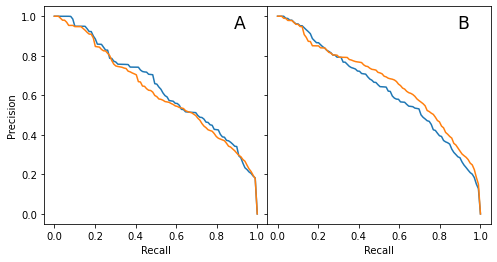

In [42]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4), sharey=True, constrained_layout = True)
fig.subplots_adjust(wspace=0)

x = np.linspace(0,1,100)

auc1 = np.mean(unfilt_dicts['1yd_ASMA']['Normal LR']['Stats']['AUC'])
ax1.plot(x, unfilt_dicts['1yd_ASMA']['Normal LR']['PR Curves'].mean(axis=0))

auc2 = np.mean(unfilt_dicts['1yd_no_ASMA']['Normal LR']['Stats']['AUC'])
ax1.plot(x, unfilt_dicts['1yd_no_ASMA']['Normal LR']['PR Curves'].mean(axis=0))

ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.text(0.85, 0.9, 'A', size='xx-large', transform=ax1.transAxes)

# ------------------------------------------------------------------------------------------------------------

auc3 = np.mean(unfilt_dicts['2yd_ASMA']['Normal LR']['Stats']['AUC'])
ax2.plot(x, unfilt_dicts['2yd_ASMA']['Normal LR']['PR Curves'].mean(axis=0))

auc4 = np.mean(unfilt_dicts['2yd_no_ASMA']['Normal LR']['Stats']['AUC'])
ax2.plot(x, unfilt_dicts['2yd_no_ASMA']['Normal LR']['PR Curves'].mean(axis=0))

ax2.set_xlabel('Recall')
ax2.text(0.85, 0.9, 'B', size='xx-large', transform=ax2.transAxes)

fig.savefig('./Prognosis_Paper_Plots/PR_Curves.pdf', bbox_inches='tight')

# Stats Plots

## 1 year death

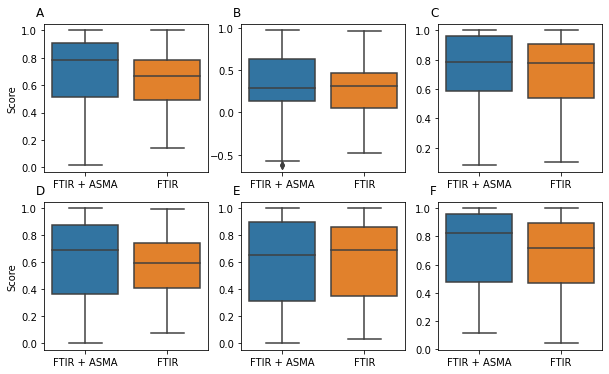

In [43]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10,6))
fig.subplots_adjust(wspace=0.2)

for ax, name, let in zip(axes.flatten(), joined_sets.columns, string.ascii_uppercase):
    ax = sns.boxplot(data=joined_sets.query('Set in ["1yd_ASMA", "1yd_no_ASMA"]').reset_index(), x='Set', y=name, ax=ax)
    ax.set_xticklabels(['FTIR + ASMA', 'FTIR'])
    ax.set_xlabel(None)
    if let in ['A', 'D']:
        ax.set_ylabel('Score')
    else:
        ax.set_ylabel(None)
    ax.text(-0.05, 1.05, let, size='large', transform=ax.transAxes)


fig.savefig('./Prognosis_Paper_Plots/Stats_Plots/Stats_Plot_1yeardeath.pdf', bbox_inches='tight')

## 2 year death

In [44]:
list(zip(joined_sets.columns, string.ascii_uppercase))

[('AUC', 'A'),
 ('MCC', 'B'),
 ('Specificity', 'C'),
 ('Sensitivity', 'D'),
 ('PPV', 'E'),
 ('NPV', 'F')]

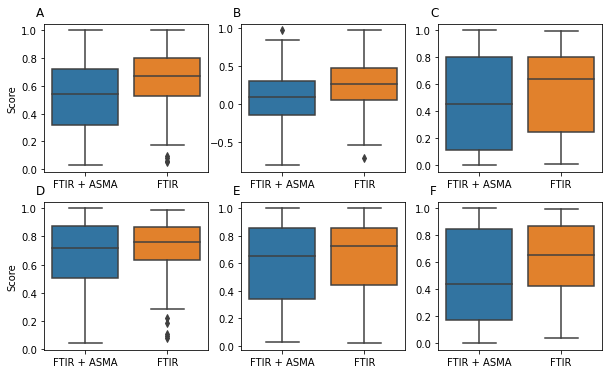

In [45]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10,6))
fig.subplots_adjust(wspace=0.2)

for ax, name, let in zip(axes.flatten(), joined_sets.columns, string.ascii_uppercase):
    ax = sns.boxplot(data=joined_sets.query('Set in ["2yd_ASMA", "2yd_no_ASMA"]').reset_index(), x='Set', y=name, ax=ax)
    ax.set_xticklabels(['FTIR + ASMA', 'FTIR'])
    ax.set_xlabel(None)
    if let in ['A', 'D']:
        ax.set_ylabel('Score')
    else:
        ax.set_ylabel(None)
    ax.text(-0.05, 1.05, let, size='large', transform=ax.transAxes)

fig.savefig('./Prognosis_Paper_Plots/Stats_Plots/Stats_Plot_2yeardeath.pdf', bbox_inches='tight')

# ROC + PR

## 1 year death

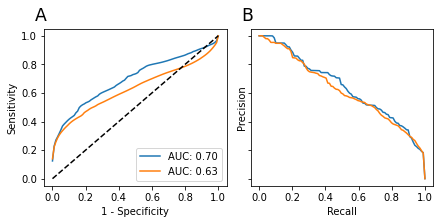

In [46]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6,3), sharey=True, constrained_layout = True)

x = np.linspace(0,1,100)

auc1 = np.mean(unfilt_dicts['1yd_ASMA']['Normal LR']['Stats']['AUC'])
ax1.plot(x, unfilt_dicts['1yd_ASMA']['Normal LR']['ROC Curves'].mean(axis=0), label=f'AUC: {auc1:0.2f}')

auc2 = np.mean(unfilt_dicts['1yd_no_ASMA']['Normal LR']['Stats']['AUC'])
ax1.plot(x, unfilt_dicts['1yd_no_ASMA']['Normal LR']['ROC Curves'].mean(axis=0), label=f'AUC: {auc2:0.2f}')

ax1.plot([0,1],[0,1], ls='--', c='black')
ax1.set_xlabel('1 - Specificity')
ax1.set_ylabel('Sensitivity')
ax1.text(-0.05, 1.05, 'A', size='xx-large', transform=ax1.transAxes)
ax1.legend(loc=4)

# ------------------------------------------------------------------------------------------------------------

auc3 = np.mean(unfilt_dicts['1yd_ASMA']['Normal LR']['Stats']['AUC'])
ax2.plot(x, unfilt_dicts['1yd_ASMA']['Normal LR']['PR Curves'].mean(axis=0))

auc4 = np.mean(unfilt_dicts['1yd_no_ASMA']['Normal LR']['Stats']['AUC'])
ax2.plot(x, unfilt_dicts['1yd_no_ASMA']['Normal LR']['PR Curves'].mean(axis=0))

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.text(-0.05, 1.05, 'B', size='xx-large', transform=ax2.transAxes)
fig.savefig('./Prognosis_Paper_Plots/ROC_PR_Curves/1yeardeath.pdf', bbox_inches='tight')

## 2 year death

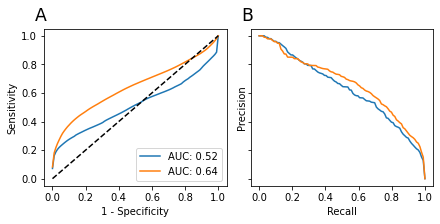

In [47]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6,3), sharey=True, constrained_layout = True)

x = np.linspace(0,1,100)

auc1 = np.mean(unfilt_dicts['2yd_ASMA']['Normal LR']['Stats']['AUC'])
ax1.plot(x, unfilt_dicts['2yd_ASMA']['Normal LR']['ROC Curves'].mean(axis=0), label=f'AUC: {auc1:0.2f}')

auc2 = np.mean(unfilt_dicts['2yd_no_ASMA']['Normal LR']['Stats']['AUC'])
ax1.plot(x, unfilt_dicts['2yd_no_ASMA']['Normal LR']['ROC Curves'].mean(axis=0), label=f'AUC: {auc2:0.2f}')

ax1.plot([0,1],[0,1], ls='--', c='black')
ax1.set_xlabel('1 - Specificity')
ax1.set_ylabel('Sensitivity')
ax1.text(-0.05, 1.05, 'A', size='xx-large', transform=ax1.transAxes)
ax1.legend(loc=4)

# ------------------------------------------------------------------------------------------------------------

auc3 = np.mean(unfilt_dicts['2yd_ASMA']['Normal LR']['Stats']['AUC'])
ax2.plot(x, unfilt_dicts['2yd_ASMA']['Normal LR']['PR Curves'].mean(axis=0))

auc4 = np.mean(unfilt_dicts['2yd_no_ASMA']['Normal LR']['Stats']['AUC'])
ax2.plot(x, unfilt_dicts['2yd_no_ASMA']['Normal LR']['PR Curves'].mean(axis=0))

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.text(-0.05, 1.05, 'B', size='xx-large', transform=ax2.transAxes)
fig.savefig('./Prognosis_Paper_Plots/ROC_PR_Curves/2yeardeath.pdf', bbox_inches='tight')

# Survival Analysis

## 1 year death

## Joined

0.000
0.009


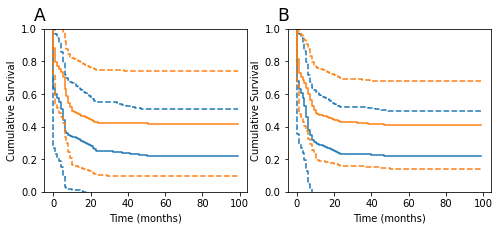

In [48]:
fig, axes = plt.subplots(ncols=2, figsize=(8,3))
fig.subplots_adjust(wspace=0.2)

for ax, subset, let in zip(axes.flatten(), ['1yd_ASMA', '1yd_no_ASMA'], string.ascii_uppercase):

    surv_dict = unfilt_dicts[subset]['Normal LR']
    km_plots(surv_dict['TSI'], surv_dict['FSI'], axin=ax);
    ax.text(-0.05, 1.05, let, size='xx-large', transform=ax.transAxes)

    p_m = np.array(surv_dict['Survival_P'])[:,1].mean()
    p_std = np.array(surv_dict['Survival_P'])[:,1].std()
    print(f'{p_m:0.3f}')

fig.savefig('./Prognosis_Paper_Plots/Survival/1yeardeath_Joined.pdf', bbox_inches='tight')
#fig.axes[0].text(0.80, 0.90, f'{p_m:0.7f}', size='x-large', transform=fig.axes[0].transAxes)

### ASMA

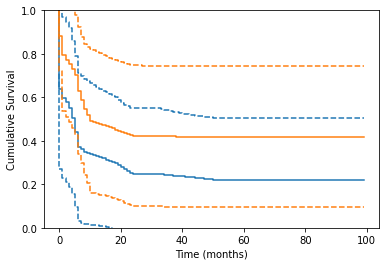

In [49]:
surv_dict = unfilt_dicts['1yd_ASMA']['Normal LR']

fig1 = km_plots(surv_dict['TSI'], surv_dict['FSI']);

p_m = np.array(surv_dict['Survival_P'])[:,1].mean()
p_std = np.array(surv_dict['Survival_P'])[:,1].std()
fig.savefig('./Prognosis_Paper_Plots/Survival/1yeardeath_ASMA.pdf', bbox_inches='tight')
#fig.axes[0].text(0.80, 0.90, f'{p_m:0.7f}', size='x-large', transform=fig.axes[0].transAxes)

### No ASMA

AttributeError: 'AxesSubplot' object has no attribute 'savefig'

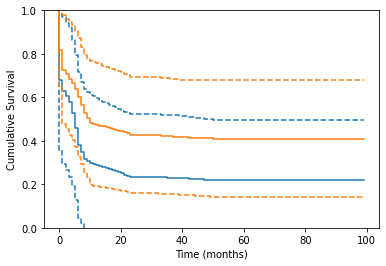

In [50]:
### ASMA
surv_dict = unfilt_dicts['1yd_no_ASMA']['Normal LR']

fig = km_plots(surv_dict['TSI'], surv_dict['FSI']);

p_m = np.array(surv_dict['Survival_P'])[:,1].mean()
p_std = np.array(surv_dict['Survival_P'])[:,1].std()
fig.savefig('./Prognosis_Paper_Plots/Survival/1yeardeath_no_ASMA.pdf', bbox_inches='tight')

#fig.axes[0].text(0.80, 0.90, f'{p_m:0.7f}', size='x-large', transform=fig.axes[0].transAxes)

## 2 year death

## Joined

0.000
0.003


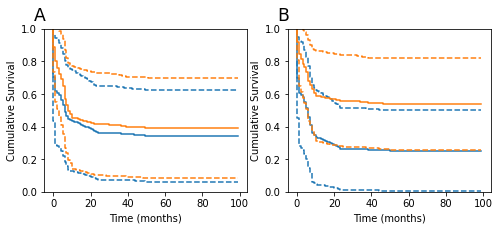

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(8,3))
fig.subplots_adjust(wspace=0.2)

for ax, subset, let in zip(axes.flatten(), ['2yd_ASMA', '2yd_no_ASMA'], string.ascii_uppercase):

    surv_dict = unfilt_dicts[subset]['Normal LR']
    km_plots(surv_dict['TSI'], surv_dict['FSI'], axin=ax);
    ax.text(-0.05, 1.05, let, size='xx-large', transform=ax.transAxes)

    p_m = np.array(surv_dict['Survival_P'])[:,1].mean()
    p_std = np.array(surv_dict['Survival_P'])[:,1].std()
    print(f'{p_m:0.3f}')

fig.savefig('./Prognosis_Paper_Plots/Survival/2yeardeath_Joined.pdf', bbox_inches='tight')
#fig.axes[0].text(0.80, 0.90, f'{p_m:0.7f}', size='x-large', transform=fig.axes[0].transAxes)

### ASMA

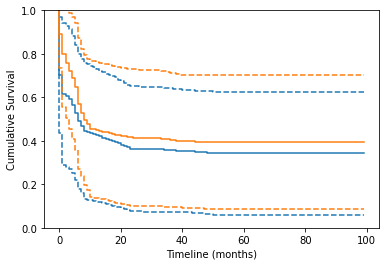

In [ ]:
surv_dict = unfilt_dicts['2yd_ASMA']['Normal LR']

fig = km_plots(surv_dict['TSI'], surv_dict['FSI']);

p_m = np.array(surv_dict['Survival_P'])[:,1].mean()
p_std = np.array(surv_dict['Survival_P'])[:,1].std()
fig.savefig('./Prognosis_Paper_Plots/Survival/2yeardeath_ASMA.pdf', bbox_inches='tight')

#fig.axes[0].text(0.80, 0.90, f'{p_m:0.7f}', size='x-large', transform=fig.axes[0].transAxes)

### No ASMA

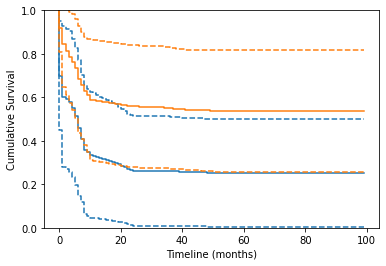

In [ ]:
### ASMA
surv_dict = unfilt_dicts['2yd_no_ASMA']['Normal LR']

fig = km_plots(surv_dict['TSI'], surv_dict['FSI']);

p_m = np.array(surv_dict['Survival_P'])[:,1].mean()
p_std = np.array(surv_dict['Survival_P'])[:,1].std()
fig.savefig('./Prognosis_Paper_Plots/Survival/2yeardeath_no_ASMA.pdf', bbox_inches='tight')

#fig.axes[0].text(0.80, 0.90, f'{p_m:0.7f}', size='x-large', transform=fig.axes[0].transAxes)

# LDA Plots

## 1 year death

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, FunctionTransformer, OneHotEncoder, MinMaxScaler

In [ ]:
numeric_pipe = Pipeline(["Normalise spectra", FunctionTransformer(normalize, kw_args = {"axis": 1})),
("Scaler", MinMaxScaler()),
("PCA", PCA(npca=8)])

categorical_pipe = Pipeline([
    ("OneHot", OneHotEncoder())
])

in_df = total.reset_total_p('ASMA').dropna(subset=['ASMA'])#.sample(frac=0.05)
in_df.columns = [str(col) for col in in_df.columns]

ct = make_column_transformer(
    (numeric_pipe,     make_column_selector(dtype_include=np.number)),
    (categorical_pipe, make_column_selector(dtype_include=object))
)

lda_pipe = Pipeline([('CT', ct), ('LDA', lda)])

In [ ]:
c = ct.fit_transform(total_p)

ValueError: No valid specification of the columns. Only a scalar, list or slice of all integers or all strings, or boolean mask is allowed

In [ ]:
total_lda = pd.DataFrame(lda_pipe.fit_transform(in_df, in_df.reset_index()['2year']), index=in_df.index, columns=['LDA_1'])

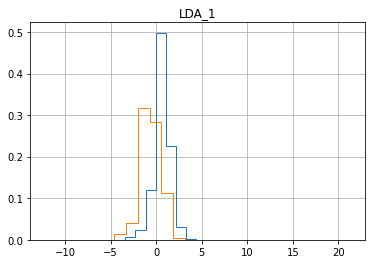

In [ ]:
fig, ax = plt.subplots()

for name, df in total_lda.groupby('2year'):

    df.hist(ax=ax, density=True, histtype='step', bins=20)

# LDA Plots

## 1 year death

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, FunctionTransformer, OneHotEncoder, MinMaxScaler

In [ ]:
numeric_pipe = Pipeline(["Normalise spectra", FunctionTransformer(normalize, kw_args = {"axis": 1})),
("Scaler", MinMaxScaler()),
("PCA", PCA(npca=8)])

categorical_pipe = Pipeline([
    ("OneHot", OneHotEncoder())
])

in_df = total.reset_total_p('ASMA').dropna(subset=['ASMA'])#.sample(frac=0.05)
in_df.columns = [str(col) for col in in_df.columns]

ct = make_column_transformer(
    (numeric_pipe,     make_column_selector(dtype_include=np.number)),
    (categorical_pipe, make_column_selector(dtype_include=object))
)

lda_pipe = Pipeline([('CT', ct), ('LDA', lda)])

In [ ]:
c = ct.fit_transform(total_p)

ValueError: No valid specification of the columns. Only a scalar, list or slice of all integers or all strings, or boolean mask is allowed

In [ ]:
total_lda = pd.DataFrame(lda_pipe.fit_transform(in_df, in_df.reset_index()['2year']), index=in_df.index, columns=['LDA_1'])

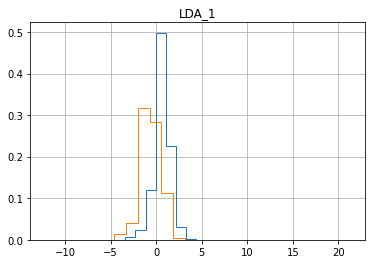

In [ ]:
fig, ax = plt.subplots()

for name, df in total_lda.groupby('2year'):

    df.hist(ax=ax, density=True, histtype='step', bins=20)